### Import Library ###

In [1]:
# Import section
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
from skimage.exposure import cumulative_distribution

### Loading Image ###

In [2]:
# image path
image_path = './assets/images/groupImage.jpg'
image = cv2.imread(image_path)

## 3.1 Image Pixel Adjustment (gamma) ##

In [6]:
gamma = [0.1, 3]
frame_rate = 30
k = 7

out_path = './assets/video/ac3.mp4'

(h, w) = image.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
writer = cv2.VideoWriter(out_path, fourcc, frame_rate, (w,h))

def pixel_adjustment(img, gamma):
    return (((img / 255) ** gamma) * 255).astype('uint8')

n_frames = k * frame_rate
ratio_change = (gamma[1] - gamma[0]) / n_frames
for i in range(n_frames + 1):
    g = 0.1 + (i * ratio_change)
    frame = pixel_adjustment(image, g)
    writer.write(frame)

for i in range(n_frames + 1):
    g = 3 - (i * ratio_change)
    frame = pixel_adjustment(image, g)
    writer.write(frame)

writer.release()


## 3.2 Image Histogram Equalization ##

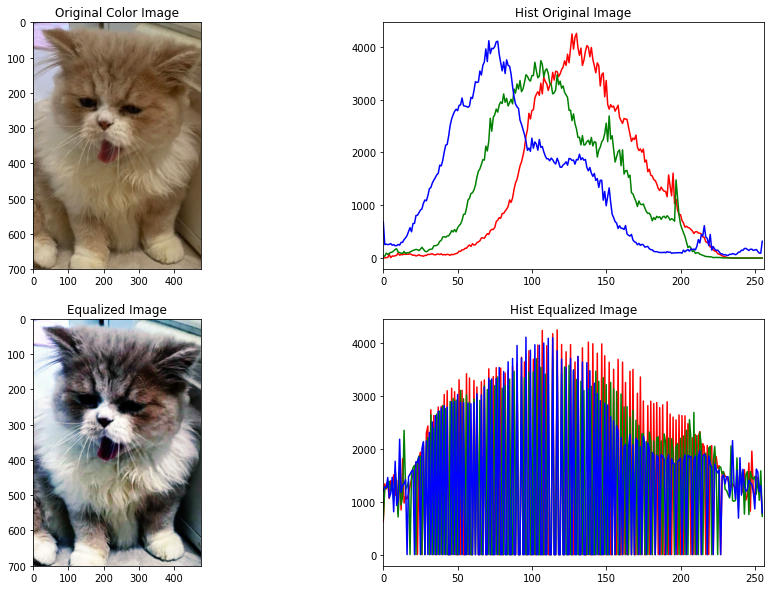

In [3]:
color = ('r','g','b')
plt.figure(figsize=(15,10))
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image_plot = plt.subplot(2,2,1)
plt.imshow(rgb_image)
plt.title('Original Color Image')


hist_original_image = plt.subplot(2,2,2)
for channel,col in enumerate(color):
    histr = cv2.calcHist([rgb_image],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Hist Original Image')

equalize_image_plt = plt.subplot(2,2,3)
r,g,b = cv2.split(rgb_image)
equalize_image = cv2.merge([cv2.equalizeHist(r),cv2.equalizeHist(g),cv2.equalizeHist(b)])
plt.imshow(equalize_image)
plt.title('Equalized Image')

hist_equalize_image = plt.subplot(2,2,4)
for channel,col in enumerate(color):
    histr = cv2.calcHist([equalize_image],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Hist Equalized Image')
plt.show()

## 3.3 Image Histogram Matching ##

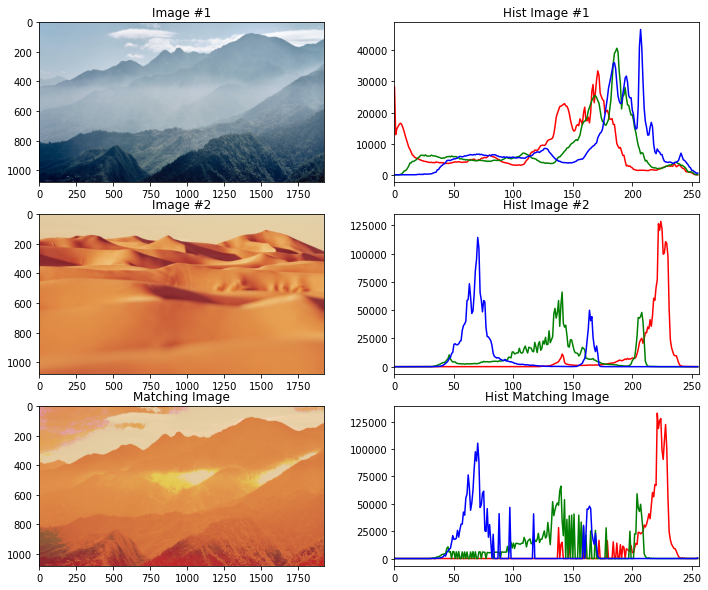

In [4]:
dim = (1920, 1080)
img1 = cv2.resize(cv2.cvtColor(cv2.imread('./assets/images/hill.jpg'),cv2.COLOR_BGR2RGB),dim)
img2 = cv2.resize(cv2.cvtColor(cv2.imread('./assets/images/desert.jpg'),cv2.COLOR_BGR2RGB),dim)
# img1, img2 = img1, img2
color = ('r', 'g', 'b')

def cdf(im):
    c, b = cumulative_distribution(im)
    for i in range(b[0]):
        c = np.insert(c, 0,0)
    for i in range(b[-1]+1, 256):
        c = np.append(c, 1)
    return c

def hist_matching(c ,c_t,im):
    b = np.interp(c , c_t, np.arange(256))
    pix_repl = {i:b[i] for i in range(256)}
    mp = np.arange(0,256)
    for (k,v) in pix_repl.items():
        mp[k] = v
    s = im.shape
    im = np.reshape(mp[im.ravel()], im.shape)
    im= np.reshape(im,s)
    return im


plt.figure(figsize=(12,10))
hill_image_plot = plt.subplot(3,2,1)
plt.imshow(img1)
plt.title('Image #1')


hist_hill_image = plt.subplot(3,2,2)
for channel,col in enumerate(color):
    histr = cv2.calcHist([img1],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Hist Image #1')


desert_image_plt = plt.subplot(3,2,3)
plt.imshow(img2)
plt.title('Image #2')

hist_desert_image = plt.subplot(3,2,4)
for channel,col in enumerate(color):
    histr = cv2.calcHist([img2],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Hist Image #2')

matching_channel = []
for channel, col in enumerate(color):
    cdf_img1 = cdf(img1[:, :, channel])
    cdf_img2 = cdf(img2[:, :, channel])
    matching_channel.append(hist_matching(cdf_img1, cdf_img2, img1[:, :, channel]))

matching_image = cv2.merge(matching_channel)
matching_image = matching_image.astype('uint8')
# print(matching_image.dtype)

matching_image_plot = plt.subplot(3,2,5)
plt.imshow(matching_image.astype('uint8'))
plt.title('Matching Image')

hist_matching_image = plt.subplot(3,2,6)
for channel,col in enumerate(color):
    histr = cv2.calcHist([matching_image],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Hist Matching Image')

plt.show()